# Computing the Bayesian Hilbert Transform-DRT

In this tutorial example, we will show evaluate the BHT-DRT performance using a two ZARCs model with drift.

In [1]:
# import the libraries
import numpy as np
from math import pi, log10
import matplotlib.pyplot as plt
import seaborn as sns

# core library
import Bayes_HT
import importlib
importlib.reload(Bayes_HT)

<module 'Bayes_HT' from '/Users/jiapeng/Documents/Github/BHT/tutorials/Bayes_HT.py'>

In [2]:
# plot standards
plt.rc('font', family='serif', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## 1) Define the synthetic impedance experiment $Z_{\rm exp}(\omega)$

### 1.1) Define the frequency range

In [3]:
N_freqs = 81
freq_min = 10**-4   # Hz
freq_max = 10**4    # Hz
freq_vec = np.logspace(log10(freq_min), log10(freq_max), num=N_freqs, endpoint=True)
tau_vec = np.logspace(-log10(freq_max), -log10(freq_min), num=N_freqs, endpoint=True)
omega_vec = 2.*pi*freq_vec

### 1.2) Define the circuit parameters for the two ZARCs

In [4]:
# define variables for exact circuit 1
R_inf_1 = 10      # Ohm
R_ct_1 = 50       # Ohm
phi_1 = 0.8
tau_1 = 0.1       # sec

# impedance of circuit 1
T_1 = tau_1**phi_1/R_ct_1
Z_exact_1 = R_inf_1+1./(1./R_ct_1+T_1*(1j*2.*pi*freq_vec)**phi_1)

# define variables for exact circuit 2
R_inf_2 = 10      # Ohm
R_ct_2 = 50       # Ohm
phi_2 = 0.8
tau_2 = 1E0       # sec

# impedance of circuit 2
T_2 = tau_2**phi_2/R_ct_2
Z_exact_2 = R_inf_2+1./(1./R_ct_2+T_2*(1j*2.*pi*freq_vec)**phi_2)

### 1.3) Generate exact base impedance $Z_{\rm base}(\omega)$

In [5]:
# base model with no drift
Z_base = Z_exact_1+Z_exact_2

### 1.4) Apply the drift model on $R_{\rm ct,2}$ such that $R_{\rm ct,2}(\omega)=R_{\rm ct,2}\zeta(\omega,\rho)$

In [6]:
rho = 1.5
zeta = np.flip(np.logspace(0, np.log10(rho), N_freqs))

### 1.5) Generate the stochastic experiment $Z_{\rm exp}(\omega)$, here $Z_{\rm exp}(\omega)=Z_{\rm exact}(\omega)+\sigma_n(\varepsilon_{\rm re}+i\varepsilon_{\rm im})$

In [7]:
rng = np.random.seed(121295)
sigma_n_exp = 0.1       # Ohm
Z_noise = sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

R_ct_2_corrupt = R_ct_2*zeta
T_2 = tau_2**phi_2/R_ct_2_corrupt
Z_corrupt = R_inf_2 + 1./(1./R_ct_2_corrupt + T_2*(1j*2.*pi*freq_vec)**phi_2)

Z_exact = Z_exact_1 + Z_corrupt
Z_exp = Z_exact + Z_noise

### 1.6) show the impedance in Nyquist plot

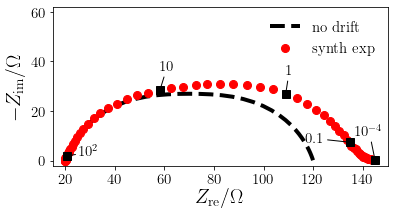

In [8]:
fig, ax = plt.subplots()
plt.plot(Z_base.real, -Z_base.imag, linestyle='--', linewidth=4, color='black', label='no drift')
plt.plot(np.real(Z_exp), -Z_exp.imag, 'o', markersize=8, color='red', label='synth exp')
plt.plot(np.real(Z_exp[0:70:20]), -np.imag(Z_exp[0:70:20]), 's', markersize=8, color="black")
plt.plot(np.real(Z_exp[30]), -np.imag(Z_exp[30]), 's', markersize=8, color="black")

plt.annotate(r'$10^{-4}$', xy=(np.real(Z_exp[0]), -np.imag(Z_exp[0])), 
              xytext=(np.real(Z_exp[0])-8, 10-np.imag(Z_exp[0])), 
              arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$0.1$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
              xytext=(np.real(Z_exp[20])-18, -np.imag(Z_exp[20])), 
              arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
              xytext=(np.real(Z_exp[30]), 8-np.imag(Z_exp[30])), 
              arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
              xytext=(np.real(Z_exp[40]), 8-np.imag(Z_exp[40])), 
              arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^2$', xy=(np.real(Z_exp[60]), -np.imag(Z_exp[60])), 
              xytext=(np.real(Z_exp[60])+5, -np.imag(Z_exp[60])), 
              arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')
# 
plt.xlim(15, 150)
plt.ylim(-2, 62)
plt.xticks(range(20, 150, 20))
plt.yticks(range(0, 62, 20))
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 2) Calculate the DRT impedance $Z_{\rm DRT}(\omega)$ and the Hilbert transformed impedance $Z_{\rm H}(\omega)$

### 2.1) optimize the hyperparamters

In [9]:
# set the intial parameters
sigma_n = 1
sigma_beta = 20
sigma_lambda = 100

theta_0 = np.array([sigma_n, sigma_beta, sigma_lambda])
data_real, data_imag, scores = Bayes_HT.HT_est(theta_0, Z_exp, freq_vec, tau_vec)

sigma_n; sigma_beta; sigma_lambda
9.97217e-02     20.009464     99.999794 
9.70185e-02     20.011357     99.999661 
9.69819e-02     20.728546     99.967536 
9.69927e-02     22.311529     99.881276 
9.69890e-02     25.506931     99.666583 
9.69891e-02     27.489641     99.489731 
9.69880e-02     28.880257     99.320170 
9.69888e-02     29.447874     99.203145 
9.69895e-02     29.751155     99.081924 
9.69917e-02     30.077925     98.851869 
9.69961e-02     30.462796     98.436710 
9.70043e-02     30.987164     97.672042 
9.70206e-02     31.757625     96.234005 
9.70542e-02     33.014650     93.452555 
9.75939e-02     50.375607     50.591621 
9.77746e-02     52.663874     44.769772 
9.83092e-02     51.548831     46.242285 
9.88636e-02     49.805019     47.524522 
9.94384e-02     46.569664     49.353945 
1.00093e-01     40.288597     52.302502 
1.00359e-01     35.128751     53.877157 
1.00339e-01     34.225209     51.618706 
9.98185e-02     34.810241     45.930342 
9.84633e-02     34.5110

### 2.2) Calculate the real part of the $Z_{\rm DRT}(\omega)$ and the imaginary part of the $Z_{\rm H}(\omega)$

#### 2.2.1) Bayesian regression to obtain the real part of impedance for both mean and covariance

In [10]:
mu_Z_re = data_real.get('mu_Z')
cov_Z_re = np.diag(data_real.get('Sigma_Z'))

# the mean and covariance of $R_\infty$
mu_R_inf = data_real.get('mu_gamma')[0]
cov_R_inf = np.diag(data_real.get('Sigma_gamma'))[0]

#### 2.2.2) Calculate the real part of DRT impedance for both mean and covariance

In [11]:
mu_Z_DRT_re = data_real.get('mu_Z_DRT')
cov_Z_DRT_re = np.diag(data_real.get('Sigma_Z_DRT'))

#### 2.2.3) Calculate the imaginary part of HT impedance for both mean and covariance

In [12]:
mu_Z_H_im = data_real.get('mu_Z_H')
cov_Z_H_im = np.diag(data_real.get('Sigma_Z_H'))

#### 2.2.4) Estimate the $\sigma_n$

In [13]:
sigma_n_re = data_real.get('theta')[0]

### 2.3) Calculate the imaginary part of the $Z_{\rm DRT}(\omega)$ and the real part of the $Z_{\rm H}(\omega)$

In [14]:
# 2.3.1 Bayesian regression
mu_Z_im = data_imag.get('mu_Z')
cov_Z_im = np.diag(data_imag.get('Sigma_Z'))

# the mean and covariance of the inductance $L_0$
mu_L_0 = data_imag.get('mu_gamma')[0]
cov_L_0 = np.diag(data_imag.get('Sigma_gamma'))[0]

# 2.3.2 DRT part
mu_Z_DRT_im = data_imag.get('mu_Z_DRT')
cov_Z_DRT_im = np.diag(data_imag.get('Sigma_Z_DRT'))

# 2.3.3 HT prediction
mu_Z_H_re = data_imag.get('mu_Z_H')
cov_Z_H_re = np.diag(data_imag.get('Sigma_Z_H'))

# 2.3.4 estimated sigma_n
sigma_n_im = data_imag.get('theta')[0]

## 3) Plot the BHT_DRT

### 3.1) plot the imaginary parts of impedance for both Bayesian regression and the synthetic experiment

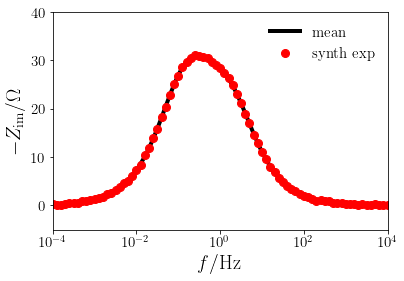

In [15]:
band = np.sqrt(cov_Z_im)
plt.fill_between(freq_vec, -mu_Z_im-3*band, -mu_Z_im+3*band,  facecolor='lightgrey')
plt.semilogx(freq_vec, -mu_Z_im, linewidth=4, color='black', label='mean')
plt.semilogx(freq_vec, -Z_exp.imag, 'o', markersize=8, color='red', label='synth exp')
plt.xlim(1E-4, 1E4)
plt.ylim(-5, 40)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

### 3.2) plot the real parts of impedance for both Hilbert transform and the synthetic experiment

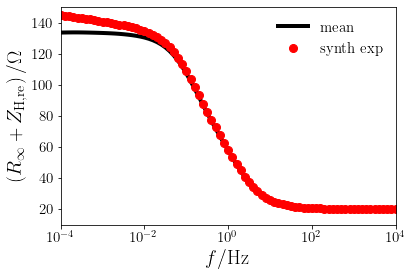

In [16]:
mu_Z_H_re_agm = mu_R_inf + mu_Z_H_re 
band_agm = np.sqrt(cov_R_inf + cov_Z_H_re + sigma_n_im**2)
plt.fill_between(freq_vec, mu_Z_H_re_agm-3*band_agm, mu_Z_H_re_agm+3*band_agm,  facecolor='lightgrey')
plt.semilogx(freq_vec, mu_Z_H_re_agm, linewidth=4, color='black', label='mean')
plt.semilogx(freq_vec, Z_exp.real, 'o', markersize=8, color='red', label='synth exp')
plt.xlim(1E-4, 1E4)
plt.ylim(10, 150)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\left(R_\infty + Z_{\rm H, re}\right)/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

### 3.3) plot the difference between real parts of impedance for Hilbert transform and the synthetic experiment

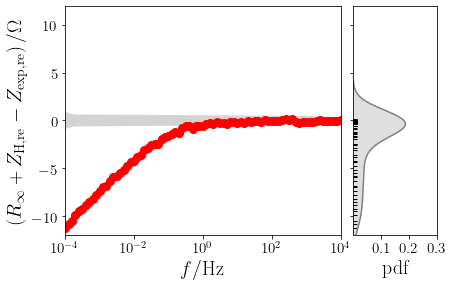

In [17]:
difference_re = mu_R_inf + mu_Z_H_re - Z_exp.real 
band = np.sqrt(cov_R_inf + cov_Z_H_re + sigma_n_im**2)

fig = plt.figure(figsize=(12,4.2), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.48, wspace=0.15)
ax1 = fig.add_subplot(gs1[0, :-1])
ax2 = fig.add_subplot(gs1[0, -1])
ax1.fill_between(freq_vec, -3*band, 3*band,  facecolor='lightgrey')
ax1.plot(freq_vec, difference_re, 'o', markersize=8, color='red')
ax1.set_xlim(1E-4, 1E4)
ax1.set_ylim(-12, 12)
ax1.set_xscale('log')
ax1.set_xlabel(r'$f/{\rm Hz}$', fontsize=20)
ax1.set_ylabel(r'$\left(R_\infty + Z_{\rm H, re} - Z_{\rm exp, re}\right)/\Omega$', fontsize=20)
# density distribution plot
sns.kdeplot(difference_re, ax=ax2, shade=True, color='grey', vertical=True)
sns.rugplot(difference_re, ax=ax2, color='black', vertical=True)
ax2.set_xlim(0, 0.3)
ax2.set_xticks(np.arange(0.1, 0.32, 0.1))
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels([])
ax2.set_ylim(-12, 12)
ax2.set_xlabel(r'pdf',fontsize=20)
plt.show()